# Workflow Notebook 
---
In this notebook, the workflow of the web page will be described, covering the entire process from downloading data, training the model, and checking for overfitting. A global explanation is provided using permutation importance to verify the validity of the explanation by removing unnecessary variables and retraining the model to ensure it is well explained. Then, a local explanation is added for the mean value of each feature to observe how the different features influence the predictions.

In [112]:
import shap
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error
from sklearn.inspection import permutation_importance

In [113]:
CSV_PATH = "../../data/breast_cancer.csv"

def load_data(path):
    data = pd.read_csv(path)
    return data

def train_model(X_train, X_test, y_train, y_test, n_estimators=2):
    model = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc}")

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Matriz de Confusión')
    plt.xlabel('Predicho')
    plt.ylabel('Real')
    plt.show('confusion_matrix.png')
    
    return model

## Train Model 
---


Accuracy: 0.958041958041958


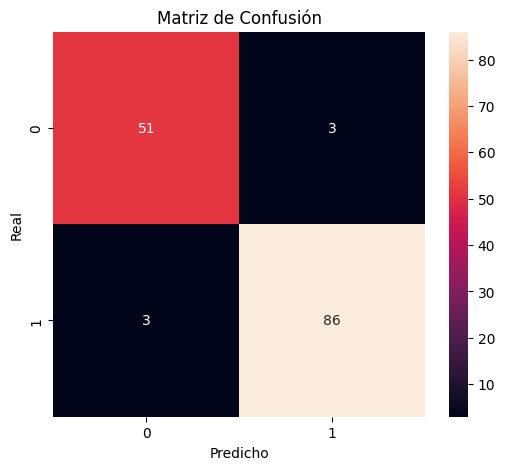

In [114]:
n_estimators=3
data = load_data(CSV_PATH)
feature_names = [c for c in data.columns if c != "target"]
X = data[feature_names].copy()
y = data["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
model = train_model(X_train, X_test, y_train, y_test, n_estimators)

### Check if the model is overfitting
---

In [115]:
#check if the model is overfitting or underfitting with MAE
y_train_pred = model.predict(X_train)
train_mae = mean_absolute_error(y_train, y_train_pred)
y_test_pred = model.predict(X_test)
test_mae = mean_absolute_error(y_test, y_test_pred)
print(f"Train MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Magnitud: {test_mae/train_mae}")

Train MAE: 0.011737089201877934
Test MAE: 0.04195804195804196
Magnitud: 3.5748251748251754


The model is not overfitting, so we can proceed with the explanability

## Global explanation
---

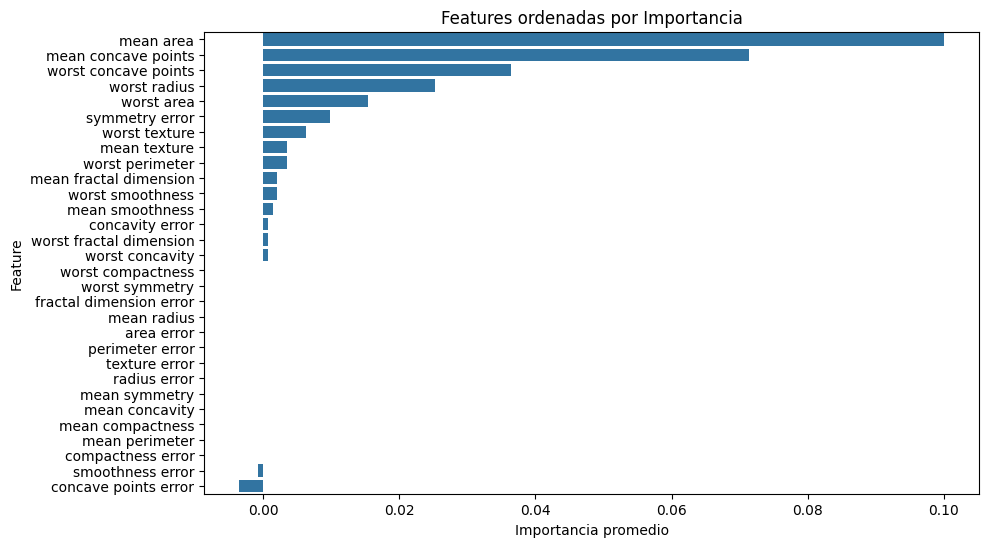

In [116]:
def calculate_fi(model, X_test, y_test):
    perm_imp = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

    df_fi = pd.DataFrame({'feature': feature_names, 'importance': perm_imp.importances_mean})
    df_fi = df_fi.sort_values(by='importance', ascending=False)

    _, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=df_fi, ax=ax)
    ax.set_xlabel("Importancia promedio")
    ax.set_ylabel("Feature")
    ax.set_title("Features ordenadas por Importancia")
    plt.show('feature_importance.png')
    return df_fi

df_fi = calculate_fi(model, X_test, y_test)

We can see that the least important columns are: `worst compactness`, `worst symmetry`, `fractal dimension error`, `mean radius`, `area error`, `perimeter error`, `texture error`, `radius error`, `mean symmetry`, `mean concavity`, `mean compactness`, `mean perimeter`, `compactness error`, `smoothness error` and `concave points error`. Now to check the validity of the explanation lets see if the new model without this columns outperforms the old one.

Accuracy: 0.965034965034965


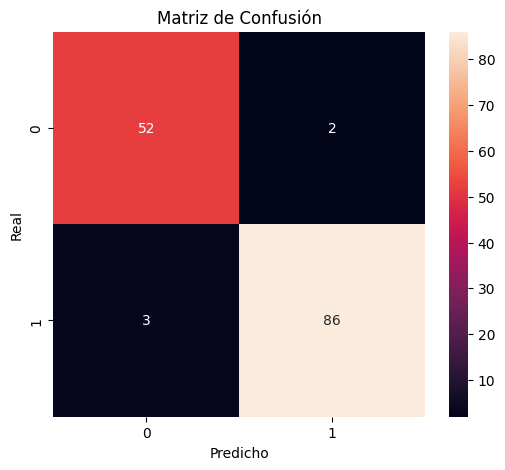

In [117]:
threshold = df_fi['importance'].quantile(0.25)
low_importance = df_fi[df_fi['importance'] <= threshold]["feature"].to_list()

stay = [f for f in feature_names if f not in low_importance]

X_sub = data[stay]
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_sub, y, test_size=0.25, random_state=42)

new_model = train_model(X_train_sub, X_test_sub, y_train_sub, y_test_sub, n_estimators=3)

### Actionable explanations
---
We can see that the new model performs slightly better than the old one  but due to the low amount of data the new model can't shine as it should although it still outperforms the old one.

## Local explanation
---
Now lets see hoy the model evaluate each column by checking teh local explanation for the mean value of each column

Se ha predecido la clase: Maligno


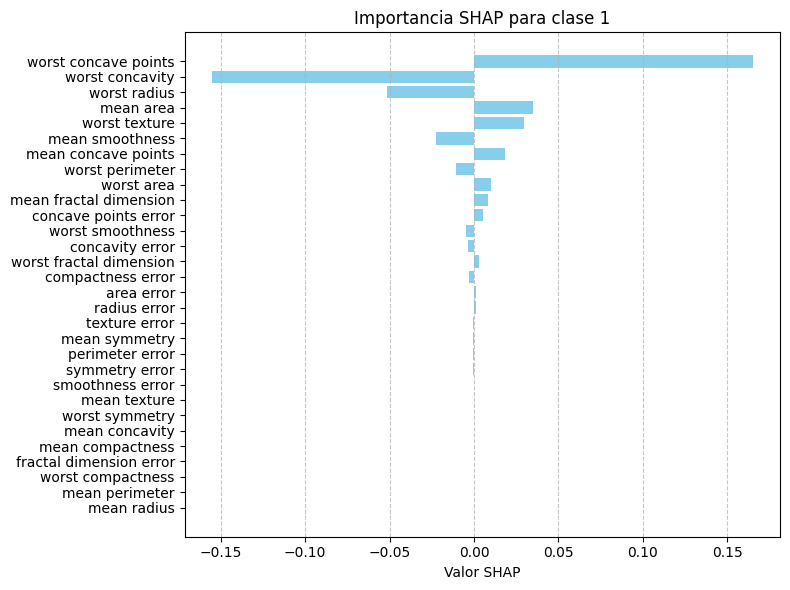

In [131]:
features = data[feature_names].mean().to_frame().T

explainer = shap.TreeExplainer(model)
prediction = model.predict(features)
pred_class = int(prediction[0])

type_map = {0: 'Benigno', 1: 'Maligno'} 

print(f"Se ha predecido la clase: {type_map[pred_class]}")

shap_values = explainer.shap_values(features)
df_shap = pd.DataFrame({'feature': feature_names, 'shap': shap_values[0][:,pred_class]})
df_shap['abs_shap'] = df_shap['shap'].abs()
df_shap_sorted = df_shap.sort_values('abs_shap', ascending=True)

plt.figure(figsize=(8, 6))
plt.barh(df_shap_sorted['feature'], df_shap_sorted['shap'], color='skyblue')
plt.xlabel('Valor SHAP')
plt.title(f'Importancia SHAP para clase {pred_class}')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

We can clearly see that for the malignant class the model understand that the mean of the features `worst concave points`, `worst texture` and `mean area` affect positively and the mean values of `worst concavity`, `worst radius` and `mean smoothness` affect negatively.

Se ha predecido la clase: Benigno


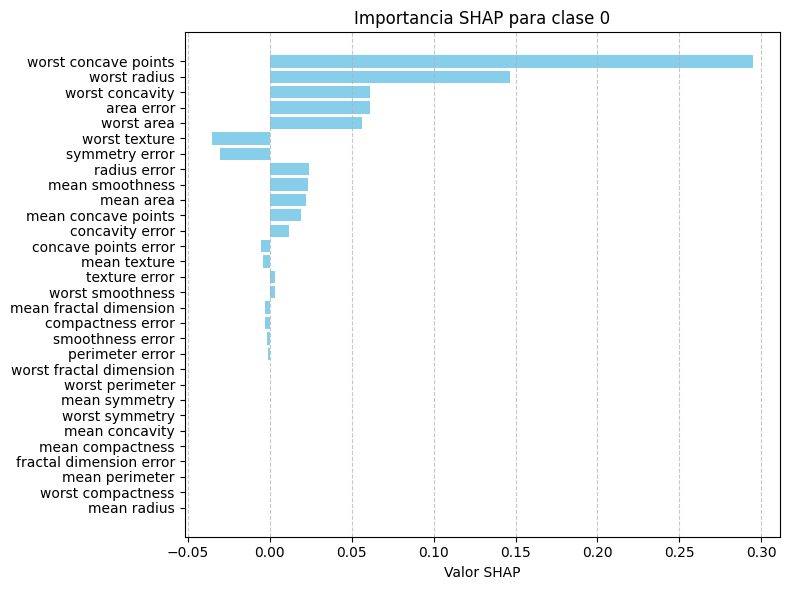

In [130]:
features = X.iloc[0].to_frame().T

explainer = shap.TreeExplainer(model)
prediction = model.predict(features)
pred_class = int(prediction[0])

type_map = {0: 'Benigno', 1: 'Maligno'} 

print(f"Se ha predecido la clase: {type_map[pred_class]}")

shap_values = explainer.shap_values(features)
df_shap = pd.DataFrame({'feature': feature_names, 'shap': shap_values[0][:,pred_class]})
df_shap['abs_shap'] = df_shap['shap'].abs()
df_shap_sorted = df_shap.sort_values('abs_shap', ascending=True)

plt.figure(figsize=(8, 6))
plt.barh(df_shap_sorted['feature'], df_shap_sorted['shap'], color='skyblue')
plt.xlabel('Valor SHAP')
plt.title(f'Importancia SHAP para clase {pred_class}')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

We can clearly see that for the benign class the model understand that the values of the features `worst concave points`, `worst radius` and `worst concavity` affect positively and the values of `worst texture` and `symetry error` affect negatively. For this feature vector the model is very confident that the output is benign, the value of `worst concave points` is really positive and helps the model dictate that the cancer is benign.